In [ ]:
!pip install keras_cv_attention_models
!pip install scikit-learn
!pip install scikeras
!pip install keras_tuner

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Dense, Dropout,
    Concatenate, GlobalAveragePooling2D, MaxPooling2D, Flatten, Add,
    AveragePooling2D, UpSampling2D, Lambda, Multiply, Reshape
)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import cv2
import tifffile
import matplotlib.pyplot as plt
from collections import Counter
from keras_cv_attention_models import backend
from keras_cv_attention_models.backend import layers, models, functional, image_data_format
from keras_cv_attention_models.attention_layers import (
    ChannelAffine, activation_by_name, batchnorm_with_activation, conv2d_no_bias,
    depthwise_conv2d_no_bias, drop_block, mlp_block, multi_head_self_attention, se_module
)
from keras_tuner import RandomSearch

# Custom metric for R-squared


  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import joblib

X_train = joblib.load('X_train.pkl')
X_test = joblib.load('X_test.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

Datasets loaded successfully.


In [ ]:
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (ss_res / ss_tot)

In [ ]:
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

def se_resnet_block(x, filters, kernel_size=3, stride=1, reduction=16):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x, reduction)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def se_resnet_model(input_shape=(9, 9, 1), dropout_rate=0.5, learning_rate=1e-4):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    for filters in [64, 128, 256]:
        x = se_resnet_block(x, filters, stride=1)
        x = se_resnet_block(x, filters, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(2)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=[MeanSquaredError(), r_squared])
    return model

# Hyperparameter tuning setup
def build_se_resnet(hp):
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    return se_resnet_model(dropout_rate=dropout_rate, learning_rate=learning_rate)

tuner = RandomSearch(
    build_se_resnet,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='se_resnet_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)


tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Retrieve the best hyperparameters and build the model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = se_resnet_model(dropout_rate=best_hp.get('dropout_rate'), learning_rate=best_hp.get('learning_rate'))

# Train the best model with the full dataset
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the best model
evaluation = best_model.evaluate(X_test, y_test)
print(f"Evaluation results: {evaluation}")


Reloading Tuner from tuner_logs/se_resnet_tuning/tuner0.json
Epoch 1/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 108.5577 - mean_squared_error: 108.5577 - r_squared: 0.2840 - val_loss: 45.7056 - val_mean_squared_error: 45.7056 - val_r_squared: 0.6794 - learning_rate: 1.5111e-04
Epoch 2/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 31.0123 - mean_squared_error: 31.0123 - r_squared: 0.7828 - val_loss: 29.5356 - val_mean_squared_error: 29.5356 - val_r_squared: 0.7941 - learning_rate: 1.5111e-04
Epoch 3/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 30.3261 - mean_squared_error: 30.3261 - r_squared: 0.7854 - val_loss: 32.8999 - val_mean_squared_error: 32.8999 - val_r_squared: 0.7733 - learning_rate: 1.5111e-04
Epoch 4/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 28.2952 - mean_squared_error: 28.2952 - r_squared: 0.8026 - val_loss: 36.8053 - val_mean_squared_error: 36.8053 - val_r_squared: 0.7434 - learning_rate: 1.5111e-04
Epoch 5/50
1002/1002 ━━━━━━━━━━

In [ ]:
best_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 9, 9, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 5, 5, 64)       │          3,200 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_54    │ (None, 5, 5, 64)       │            256 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 5, 5, 64)       │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 3, 3, 64)       │              0 │ activation_39[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 3, 3, 64)       │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 3, 3, 64)       │            256 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 3, 3, 64)       │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 3, 3, 64)       │         36,928 │ activation_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 3, 3, 64)       │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_5… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 64)             │            320 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_18 (Reshape)      │ (None, 1, 1, 64)       │              0 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_18 (Multiply)    │ (None, 3, 3, 64)       │              0 │ batch_normalization_5… │
│                           │                        │                │ reshape_18[0][0]       │
├──────────────────────

 Total params: 8,672,624 (33.08 MB)

 Trainable params: 2,889,082 (11.02 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 5,778,166 (22.04 MB)

In [ ]:
def fire_module(x, squeeze_filters, expand_filters):
    x = Conv2D(squeeze_filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    expand1x1 = Conv2D(expand_filters, (1, 1), padding='same')(x)
    expand1x1 = BatchNormalization()(expand1x1)
    expand1x1 = Activation('relu')(expand1x1)

    expand3x3 = Conv2D(expand_filters, (3, 3), padding='same')(x)
    expand3x3 = BatchNormalization()(expand3x3)
    expand3x3 = Activation('relu')(expand3x3)

    x = tf.keras.layers.concatenate([expand1x1, expand3x3])
    return x

def simplified_squeezenet(input_shape=(9, 9, 1), dropout_rate=0.5, learning_rate=1e-4):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=32)
    x = MaxPooling2D((2, 2))(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=32)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=[MeanSquaredError(),r_squared])
    return model

# Hyperparameter tuning setup
def build_simplified_squeezenet(hp):
    dropout_rate = hp.Float('dropout_rate', 0.5, 0.8, step=0.1)  # Increased minimum dropout rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    return simplified_squeezenet(dropout_rate=dropout_rate, learning_rate=learning_rate)

tuner = RandomSearch(
    build_simplified_squeezenet,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='simplified_squeezenet_tuning'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model
evaluation = best_model.evaluate(X_test, y_test)
print(f"Evaluation results: {evaluation}")


Trial 10 Complete [00h 02m 27s]
val_loss: 19.125940322875977

Best val_loss So Far: 17.55928611755371
Total elapsed time: 00h 30m 13s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 9, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 9, 9, 32)       │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 4, 4, 32)       │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 4, 4, 16)       │            528 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 4, 4, 16)       │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 4, 4, 16)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 32)       │            544 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 32)       │          4,640 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 4, 4, 32)       │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4, 4, 32)       │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 4, 4, 32)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 4, 4, 32)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 4, 64)       │              0 │ activation_1[0][0],    │
│                           │                        │                │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 2, 2, 64)       │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 2, 2, 16)       │          1,040 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2, 2, 16)       │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 13,026 (50.88 KB)

 Trainable params: 12,706 (49.63 KB)

 Non-trainable params: 320 (1.25 KB)

251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.5579 - mean_squared_error: 17.5579 - r_squared: 0.8805
Evaluation results: [17.55928611755371, 17.55928611755371, 0.8785850405693054]


In [ ]:
def conv_block(x, filters, dropout_rate):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def resize_to_match(x, ref):
    return Lambda(lambda inputs: tf.image.resize(inputs[0], tf.shape(inputs[1])[1:3]), output_shape=lambda s: (s[1][0], s[1][1], s[1][2], s[0][3]))([x, ref])

def build_unet_plus_plus(hp):
    input_shape = (9, 9, 1)
    inputs = Input(shape=input_shape)

    # Hyperparameters to tune
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)

    # Encoder
    c1 = conv_block(inputs, filters, dropout_rate)
    p1 = Conv2D(filters, (2, 2), strides=(2, 2), padding='same')(c1)

    c2 = conv_block(p1, filters * 2, dropout_rate)
    p2 = Conv2D(filters * 2, (2, 2), strides=(2, 2), padding='same')(c2)

    c3 = conv_block(p2, filters * 4, dropout_rate)
    p3 = Conv2D(filters * 4, (2, 2), strides=(2, 2), padding='same')(c3)

    # Bottleneck
    c4 = conv_block(p3, filters * 8, dropout_rate)

    # Decoder
    u3 = UpSampling2D(size=(2, 2))(c4)
    u3 = resize_to_match(u3, c3)
    u3 = concatenate([u3, c3])
    c3_up = conv_block(u3, filters * 4, dropout_rate)

    u2 = UpSampling2D(size=(2, 2))(c3_up)
    u2 = resize_to_match(u2, c2)
    u2 = concatenate([u2, c2])
    c2_up = conv_block(u2, filters * 2, dropout_rate)

    u1 = UpSampling2D(size=(2, 2))(c2_up)
    u1 = resize_to_match(u1, c1)
    u1 = concatenate([u1, c1])
    c1_up = conv_block(u1, filters, dropout_rate)

    # Global Average Pooling to reduce to (batch_size, 2)
    pooled = GlobalAveragePooling2D()(c1_up)
    outputs = Dense(2)(pooled)  # No activation function specified for regression

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

# Hyperparameter tuning with KerasTuner
tuner = kt.RandomSearch(
    build_unet_plus_plus,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='unet_plus_plus_tuning',
    project_name='unet_plus_plus'
)


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('unet_plus_plus_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),
             callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal number of filters in the conv layers is {best_hps.get('filters')}.
""")


Trial 10 Complete [00h 01m 48s]
val_loss: 166.94085693359375

Best val_loss So Far: 20.235044479370117
Total elapsed time: 02h 19m 24s

The optimal dropout rate is 0.1.
The optimal learning rate is 0.00010479183186805519.
The optimal number of filters in the conv layers is 32.



In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model
evaluation = best_model.evaluate(X_test, y_test)
print(f"Evaluation results: {evaluation}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 9, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 9, 9, 32)       │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 9, 9, 32)       │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 9, 9, 32)       │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 5, 5, 32)       │          4,128 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 5, 5, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 5, 5, 64)       │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 5, 5, 64)       │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 3, 3, 64)       │         16,448 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 3, 3, 128)      │         73,856 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 3, 3, 128)      │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 3, 3, 128)      │        147,584 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 2, 2, 128)      │         65,664 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 2, 2, 256)      │        295,168 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2, 2, 256)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 2, 2, 256)      │        590,080 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 4, 4, 256)      │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 3, 3, 256)      │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 2,032,578 (7.75 MB)

 Trainable params: 2,032,578 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 20.0949 - mean_squared_error: 20.0949 - r_squared: 0.8629
Evaluation results: [20.235044479370117, 20.235044479370117, 0.8600296378135681]


In [ ]:
def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_downsample_block(inputs, out_channel, strides=2, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    if deploy:
        return conv2d_no_bias(inputs, out_channel, 7, strides=strides, use_bias=True, padding="same", groups=input_channel, name=name + "REPARAM_1_")

    dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=7, strides=strides, padding="same", groups=input_channel, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")
    dw_2 = conv2d_no_bias(inputs, out_channel, kernel_size=3, strides=strides, padding="same", groups=input_channel, name=name + "REPARAM_2_")
    dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
    return layers.Add(name=name + "REPARAM_out")([dw_1, dw_2])

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1), num_blocks=[2, 2, 4, 2], out_channels=[48, 96, 192, 384], block_types=["conv", "conv", "conv", "conv"], mlp_ratio=3, layer_scale=1e-5, deploy=False, activation="gelu", drop_connect_rate=0, dropout=0.3, learning_rate=0.00011566756893183716):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]
    nn = rep_conv_block(inputs, stem_width, kernel_size=3, strides=2, deploy=deploy, name="stem_1_")
    nn = activation_by_name(nn, activation=activation, name="stem_1_")
    nn = rep_conv_block(nn, stem_width, kernel_size=3, strides=2, groups=stem_width, deploy=deploy, name="stem_2_")
    nn = activation_by_name(nn, activation=activation, name="stem_2_")
    nn = rep_conv_block(nn, stem_width, kernel_size=1, strides=1, deploy=deploy, name="stem_3_")
    nn = activation_by_name(nn, activation=activation, name="stem_3_")

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True
        if stack_id > 0:
            nn = rep_downsample_block(nn, out_channel, deploy=deploy, name=stack_name + "downsample_")
            nn = rep_conv_block(nn, out_channel, kernel_size=1, deploy=deploy, name=stack_name + "downsample_2_")
            nn = activation_by_name(nn, activation=activation, name=stack_name + "downsample_")

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=out_channels[-1], deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

# Build and compile the model with best hyperparameters
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])




Model: "fastvit_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 9, 9, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_1_pad      │ (None, 11, 11, 1)      │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_1_conv     │ (None, 5, 5, 48)       │            432 │ stem_1_REPARAM_1_pad[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_2_conv     │ (None, 5, 5, 48)       │             48 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_1_bn       │ (None, 5, 5, 48)       │            192 │ stem_1_REPARAM_1_conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_2_bn       │ (None, 5, 5, 48)       │            192 │ stem_1_REPARAM_2_conv… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_REPARAM_out (Add)  │ (None, 5, 5, 48)       │              0 │ stem_1_REPARAM_1_bn[0… │
│                           │                        │                │ stem_1_REPARAM_2_bn[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_1_gelu (Activation)  │ (None, 5, 5, 48)       │              0 │ stem_1_REPARAM_out[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_1_pad      │ (None, 7, 7, 48)       │              0 │ stem_1_gelu[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_1_dw_conv  │ (None, 3, 3, 48)       │            432 │ stem_2_REPARAM_1_pad[… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_2_dw_conv  │ (None, 3, 3, 48)       │             48 │ stem_1_gelu[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_1_bn       │ (None, 3, 3, 48)       │            192 │ stem_2_REPARAM_1_dw_c… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_2_bn       │ (None, 3, 3, 48)       │            192 │ stem_2_REPARAM_2_dw_c… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_2_REPARAM_out (Add)  │ (None, 3, 3, 48)       │              0 │ stem_2_REPARAM_1_bn[0… │
│                      

 Total params: 3,210,530 (12.25 MB)

 Trainable params: 3,183,266 (12.14 MB)

 Non-trainable params: 27,264 (106.50 KB)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1), num_blocks=[2, 2, 4, 2], out_channels=[32, 64, 128, 256], block_types=["conv", "conv", "conv", "conv"], mlp_ratio=3, layer_scale=1e-5, deploy=False, activation="gelu", drop_connect_rate=0, dropout=0.3, learning_rate=0.00011566756893183716):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]
    nn = rep_conv_block(inputs, stem_width, kernel_size=3, strides=1, deploy=deploy, name="stem_1_")
    nn = activation_by_name(nn, activation=activation, name="stem_1_")
    nn = rep_conv_block(nn, stem_width, kernel_size=3, strides=1, groups=stem_width, deploy=deploy, name="stem_2_")
    nn = activation_by_name(nn, activation=activation, name="stem_2_")
    nn = rep_conv_block(nn, stem_width, kernel_size=1, strides=1, deploy=deploy, name="stem_3_")
    nn = activation_by_name(nn, activation=activation, name="stem_3_")

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

# Build and compile the model with best hyperparameters
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "fastvit_custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 9, 9, 1)]            0         []                            
                                                                                                  
 stem_1_REPARAM_1_pad (Zero  (None, 11, 11, 1)            0         ['input_10[0][0]']            
 Padding2D)                                                                                       
                                                                                                  
 stem_1_REPARAM_1_conv (Con  (None, 9, 9, 32)             288       ['stem_1_REPARAM_1_pad[0][0]']
 v2D)                                                                                             
                                                                                     

KeyboardInterrupt: 

In [ ]:
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_downsample_block(inputs, out_channel, strides=2, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    if deploy:
        return conv2d_no_bias(inputs, out_channel, 7, strides=strides, use_bias=True, padding="same", groups=input_channel, name=name + "REPARAM_1_")

    dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=7, strides=strides, padding="same", groups=input_channel, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")
    dw_2 = conv2d_no_bias(inputs, out_channel, kernel_size=3, strides=strides, padding="same", groups=input_channel, name=name + "REPARAM_2_")
    dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
    return layers.Add(name=name + "REPARAM_out")([dw_1, dw_2])

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1), num_blocks=[2, 2, 4, 2], out_channels=[48, 96, 192, 384], block_types=["conv", "conv", "conv", "conv"], mlp_ratio=3, layer_scale=1e-5, deploy=False, activation="gelu", drop_connect_rate=0, dropout=0.3, learning_rate=0.00011566756893183716):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]

    # Replace stem with DenseNet block
    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)
    nn = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=12)
    nn = transition_block(nn, reduction=0.5)

    # Adjust the number of channels to be compatible with the next stage
    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True
        if stack_id > 0:
            nn = rep_downsample_block(nn, out_channel, deploy=deploy, name=stack_name + "downsample_")
            nn = rep_conv_block(nn, out_channel, kernel_size=1, deploy=deploy, name=stack_name + "downsample_2_")
            nn = activation_by_name(nn, activation=activation, name=stack_name + "downsample_")

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=out_channels[-1], deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

# Build and compile the model with best hyperparameters
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])



Model: "fastvit_custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 9, 9, 1)]            0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 5, 5, 48)             2352      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_28 (Ba  (None, 5, 5, 48)             192       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 5, 5, 48)             0         ['batch_normaliza

In [ ]:
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1), num_blocks=[2, 2, 4, 2], out_channels=[32,32,32,32], block_types=["conv", "conv", "conv", "conv"], mlp_ratio=3, layer_scale=1e-5, deploy=False, activation="gelu", drop_connect_rate=0, dropout=0.3, learning_rate=0.00011566756893183716):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]

    # Replace stem with DenseNet block
    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)
    nn = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=12)
    nn = transition_block(nn, reduction=0.5)

    # Adjust the number of channels to be compatible with the next stage
    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "fastvit_custom"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 9, 9, 1)]            0         []                            
                                                                                                  
 conv2d_223 (Conv2D)         (None, 5, 5, 32)             1568      ['input_16[0][0]']            
                                                                                                  
 batch_normalization_223 (B  (None, 5, 5, 32)             128       ['conv2d_223[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_223 (Activation  (None, 5, 5, 32)             0         ['batch_normaliza

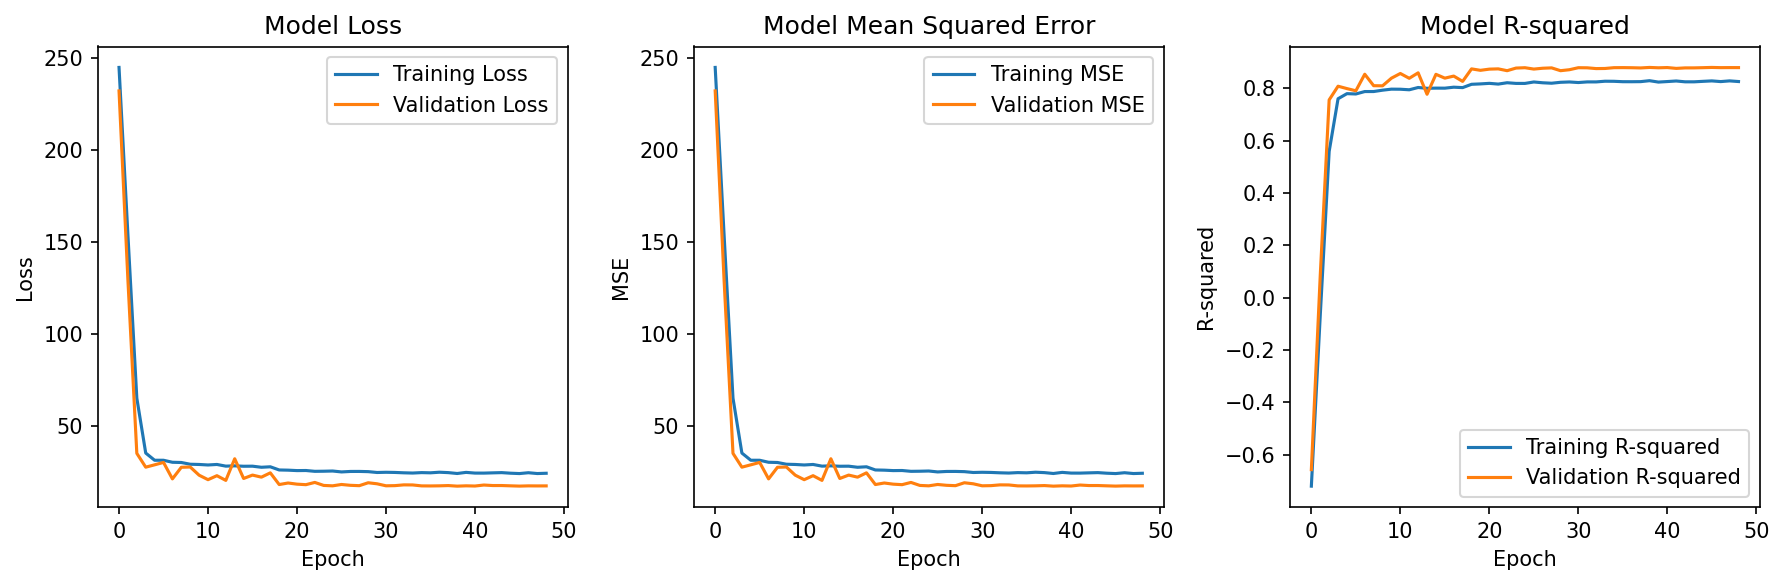

In [ ]:

# Assuming the training history is stored in 'history'
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4), dpi=150)

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot training & validation mean squared error values
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    # Plot training & validation R-squared values
    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history1)


In [ ]:
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1),
                  num_blocks=[1, 2, 3, 1],
                  out_channels=[32, 32, 32, 32],
                  block_types=["conv", "conv", "conv", "conv"],
                  mlp_ratio=3.1292064661276564,
                  layer_scale=2.470941993523134e-06,
                  deploy=False,
                  activation="gelu",
                  drop_connect_rate=0.20498216037278255,
                  dropout=0.013190760485273123,
                  learning_rate=8.402218420646587e-05):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]

    # Replace stem with DenseNet block
    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)
    #nn = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=12)
    nn = transition_block(nn, reduction=0.5)

    # Adjust the number of channels to be compatible with the next stage
    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history2 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "fastvit_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 9, 9, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 5, 5, 32)       │          1,568 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 5, 5, 32)       │            128 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 5, 5, 32)       │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 5, 5, 32)       │            128 │ activation_30[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_31             │ (None, 5, 5, 32)       │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 5, 5, 48)       │          1,536 │ activation_31[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 5, 5, 48)       │            192 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_32             │ (None, 5, 5, 48)       │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 5, 5, 12)       │          5,184 │ activation_32[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 5, 5, 44)       │              0 │ activation_30[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 5, 5, 44)       │            176 │ concatenate_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 5, 5, 44)       │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 5, 5, 48)       │          2,112 │ activation_33[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 145,902 (569.93 KB)

 Trainable params: 141,750 (553.71 KB)

 Non-trainable params: 4,152 (16.22 KB)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 267.8427 - mean_squared_error: 267.8427 - r_squared: -0.8575
Epoch 1: val_loss improved from inf to 195.61372, saving model to snr_cnr_fastvit.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 143s 71ms/step - loss: 267.8239 - mean_squared_error: 267.8239 - r_squared: -0.8574 - val_loss: 195.6137 - val_mean_squared_error: 195.6137 - val_r_squared: -0.3977 - learning_rate: 8.4022e-05
Epoch 2/100
1000/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 199.3662 - mean_squared_error: 199.3662 - r_squared: -0.3726
Epoch 2: val_loss improved from 195.61372 to 132.15034, saving model to snr_cnr_fastvit.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 199.2906 - mean_squared_error: 199.2906 - r_squared: -0.3721 - val_loss: 132.1503 - val_mean_squared_error: 132.1503 - val_r_squared: 0.0553 - learning_rate: 8.4022e-05
Epoch 3/100
1000/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 106.6062 - mean_squared_error: 106.6062 - r_squared: 0.274

In [ ]:
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1),
                  num_blocks=[1, 2, 3, 1],
                  out_channels=[32, 32, 32, 32],
                  block_types=["conv", "conv", "conv", "conv"],
                  mlp_ratio=3.1292064661276564,
                  layer_scale=2.470941993523134e-06,
                  deploy=False,
                  activation="gelu",
                  drop_connect_rate=0.20498216037278255,
                  dropout=0.013190760485273123,
                  learning_rate=8.402218420646587e-05):

    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]

    # Replace stem with DenseNet block
    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=36)
    nn = transition_block(nn, reduction=0.5)

    # Adjust the number of channels to be compatible with the next stage
    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model
model = build_fastvit()
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
model_checkpoint = ModelCheckpoint('snr_cnr_fastvit.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history3 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Model: "fastvit_custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 9, 9, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 5, 5, 32)       │          1,568 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 5, 5, 32)       │            128 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 5, 5, 32)       │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 5, 5, 32)       │            128 │ activation_45[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 5, 5, 32)       │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 5, 5, 144)      │          4,608 │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 5, 5, 144)      │            576 │ conv2d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 5, 5, 144)      │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 5, 5, 36)       │         46,656 │ activation_47[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 5, 5, 68)       │              0 │ activation_45[0][0],   │
│ (Concatenate)             │                        │                │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 5, 5, 68)       │            272 │ concatenate_18[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 5, 5, 68)       │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 5, 5, 144)      │          9,792 │ activation_48[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 514,254 (1.96 MB)

 Trainable params: 507,942 (1.94 MB)

 Non-trainable params: 6,312 (24.66 KB)

Epoch 1/100
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 264.2076 - mean_squared_error: 264.2076 - r_squared: -0.8777
Epoch 1: val_loss improved from inf to 203.31914, saving model to snr_cnr_fastvit.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 148s 78ms/step - loss: 264.1916 - mean_squared_error: 264.1916 - r_squared: -0.8776 - val_loss: 203.3191 - val_mean_squared_error: 203.3191 - val_r_squared: -0.4592 - learning_rate: 8.4022e-05
Epoch 2/100
1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 196.0118 - mean_squared_error: 196.0118 - r_squared: -0.3838
Epoch 2: val_loss improved from 203.31914 to 129.44325, saving model to snr_cnr_fastvit.keras
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 195.9697 - mean_squared_error: 195.9697 - r_squared: -0.3835 - val_loss: 129.4433 - val_mean_squared_error: 129.4433 - val_r_squared: 0.0785 - learning_rate: 8.4022e-05
Epoch 3/100
1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 108.7856 - mean_squared_error: 108.7856 - r_squared: 0.259

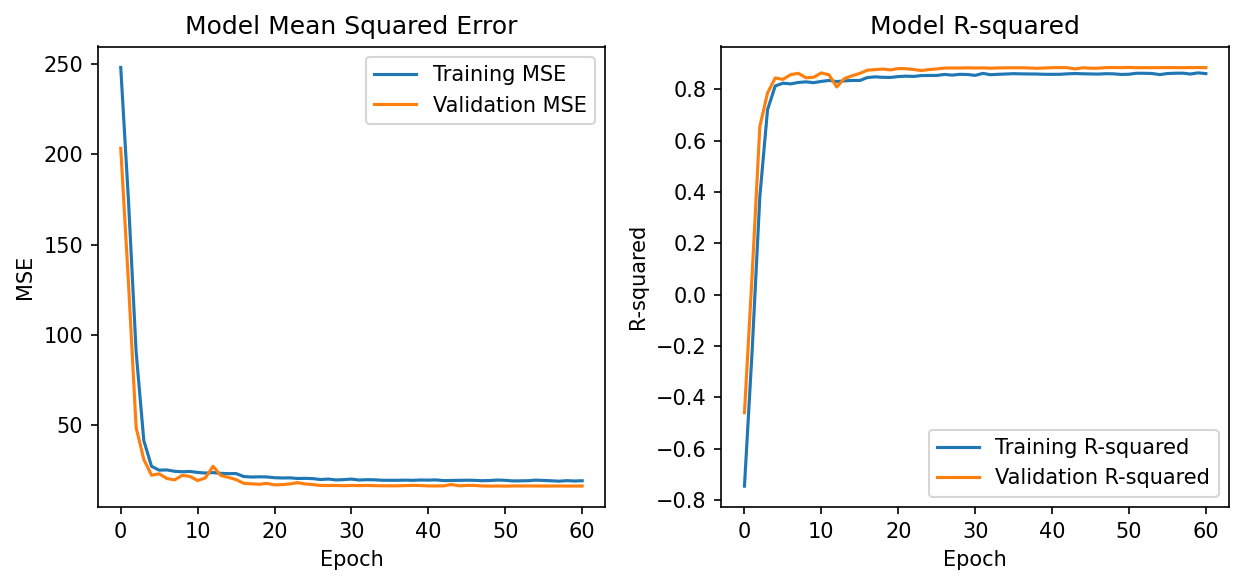

In [ ]:

# Assuming the training history is stored in 'history'
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4), dpi=150)


    # Plot training & validation mean squared error values
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.title('Model Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')

    # Plot training & validation R-squared values
    plt.subplot(1, 3, 3)
    plt.plot(history.history['r_squared'], label='Training R-squared')
    plt.plot(history.history['val_r_squared'], label='Validation R-squared')
    plt.title('Model R-squared')
    plt.xlabel('Epoch')
    plt.ylabel('R-squared')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history3)


In [ ]:
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate()([x, x1])
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def rep_conv_block(inputs, out_channel, kernel_size=3, strides=1, groups=1, deploy=False, name=""):
    input_channel = inputs.shape[-1 if image_data_format() == "channels_last" else 1]
    use_depthwise = input_channel == out_channel and groups == out_channel
    if deploy and use_depthwise:
        return depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", name=name + "REPARAM_1_")
    elif deploy:
        return conv2d_no_bias(
            inputs, out_channel, kernel_size=kernel_size, strides=strides, use_bias=True, padding="same", groups=groups, name=name + "REPARAM_1_"
        )

    use_shortcut = input_channel == out_channel and strides == 1
    if use_shortcut:
        short = batchnorm_with_activation(inputs, epsilon=1e-5, name=name + "REPARAM_0_")

    if use_depthwise:
        dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=strides, padding="same", name=name + "REPARAM_1_")
    else:
        dw_1 = conv2d_no_bias(inputs, out_channel, kernel_size=kernel_size, strides=strides, padding="same", groups=groups, name=name + "REPARAM_1_")
    dw_1 = batchnorm_with_activation(dw_1, epsilon=1e-5, name=name + "REPARAM_1_")

    if kernel_size > 1:
        if use_depthwise:
            dw_2 = depthwise_conv2d_no_bias(inputs, 1, strides=strides, name=name + "REPARAM_2_")
        else:
            dw_2 = conv2d_no_bias(inputs, out_channel, 1, strides=strides, groups=groups, name=name + "REPARAM_2_")
        dw_2 = batchnorm_with_activation(dw_2, epsilon=1e-5, name=name + "REPARAM_2_")
        out = layers.Add(name=name + "REPARAM_out")([dw_1, dw_2, short] if use_shortcut else [dw_1, dw_2])
    else:
        out = layers.Add(name=name + "REPARAM_out")([dw_1, short]) if use_shortcut else dw_1
    return out

def rep_conditional_positional_encoding(inputs, kernel_size=7, deploy=False, name=""):
    dw_1 = depthwise_conv2d_no_bias(inputs, kernel_size=kernel_size, strides=1, use_bias=True, padding="same", name=name + "REPARAM_1_")
    return dw_1 if deploy else layers.Add(name=name + "REPARAM_out")([dw_1, inputs])

def mixer_mlp_block(inputs, out_channel, mlp_ratio=3, use_attn=False, kernel_size=3, drop_rate=0, layer_scale=-1, deploy=False, activation="gelu", name=None):
    channel_axis = -1 if image_data_format() == "channels_last" else 1
    input_channel = inputs.shape[channel_axis]
    layer_scale = 0 if deploy else layer_scale
    norm_mixer = batchnorm_with_activation(inputs, epsilon=1e-5, activation=None, name=name + "mixer_")
    if use_attn:
        mixer = norm_mixer if image_data_format() == "channels_last" else layers.Permute([2, 3, 1])(norm_mixer)
        mixer = multi_head_self_attention(mixer, num_heads=input_channel // 32, qkv_bias=False, out_bias=True, name=name + "attn_")
        mixer = mixer if image_data_format() == "channels_last" else layers.Permute([3, 1, 2])(mixer)
    else:
        deep_mixer = rep_conv_block(inputs, out_channel, kernel_size=kernel_size, groups=out_channel, deploy=deploy, name=name + "mixer_")
        mixer = deep_mixer if deploy else layers.Subtract(name=name + "REPARAM_TWICE_out")([deep_mixer, norm_mixer])

    if use_attn or not deploy:
        mixer = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "1_gamma")(mixer) if layer_scale > 0 else mixer
        mixer = drop_block(mixer, drop_rate=drop_rate, name=name + "1_")
        mixer = layers.Add(name=name + ("1_out" if use_attn else "REPARAM_THIRD_out"))([mixer, inputs])

    mlp = conv2d_no_bias(mixer, out_channel, kernel_size=7, strides=1, use_bias=deploy, padding="same", groups=input_channel, name=name + "mlp_pre_")
    mlp = mlp if deploy else batchnorm_with_activation(mlp, epsilon=1e-5, activation=None, name=name + "mlp_pre_")
    mlp = mlp_block(mlp, int(out_channel * mlp_ratio), use_conv=True, activation=activation, name=name + "mlp_")

    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, axis=channel_axis, name=name + "2_gamma")(mlp) if layer_scale > 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "2_")
    return layers.Add(name=name + "2_output")([mlp, mixer])

def build_fastvit(input_shape=(9, 9, 1), num_blocks=[2, 2, 4, 2], out_channels=[32,32,32,32], block_types=["conv", "conv", "conv", "conv"], mlp_ratio=3, layer_scale=1e-5, deploy=False, activation="gelu", drop_connect_rate=0, dropout=0.3, learning_rate=0.00011566756893183716):
    input_shape = backend.align_input_shape_by_image_data_format(input_shape)
    inputs = layers.Input(input_shape)
    stem_width = out_channels[0]

    # Replace stem with DenseNet block
    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)
    #nn = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=12)
    nn = transition_block(nn, reduction=0.5)

    # Adjust the number of channels to be compatible with the next stage
    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False if block_type[0].lower() == "c" else True

        if use_attn:
            nn = rep_conditional_positional_encoding(nn, deploy=deploy, name=stack_name + "cpe_")

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = layers.GlobalAveragePooling2D()(nn)
    nn = layers.Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = layers.Dense(2, activation="linear", name="head")(nn)

    model = models.Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dense, Dropout, Concatenate, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
import pandas as pd

# Define previously implemented functions here (conv_block, dense_block, transition_block, etc.)

def build_fastvit(hp):
    input_shape = (9, 9, 1)
    num_blocks = [hp.Int('num_blocks1', 1, 4),
                  hp.Int('num_blocks2', 1, 4),
                  hp.Int('num_blocks3', 1, 4),
                  hp.Int('num_blocks4', 1, 4)]
    out_channels = [32, 32, 32, 32]  # Keep out_channels fixed
    growth_rate = hp.Int('growth_rate', min_value=12, max_value=48, step=12)
    block_types = ["conv", "conv", "conv", "conv"]  # Fixed block types
    mlp_ratio = hp.Float('mlp_ratio', 2, 4)
    layer_scale = hp.Float('layer_scale', 1e-6, 1e-4, sampling='log')
    deploy = False
    activation = hp.Choice('activation', ['gelu', 'relu'])
    drop_connect_rate = hp.Float('drop_connect_rate', 0.0, 0.5)
    dropout = hp.Float('dropout', 0.0, 0.5)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    inputs = Input(input_shape)
    stem_width = out_channels[0]

    nn = Conv2D(stem_width, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    nn = dense_block(nn, blocks=6, growth_rate=growth_rate)
    nn = transition_block(nn, reduction=0.5)

    nn = Conv2D(out_channels[0], (1, 1), use_bias=False)(nn)
    nn = BatchNormalization()(nn)
    nn = Activation('relu')(nn)

    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, block_type) in enumerate(zip(num_blocks, out_channels, block_types)):
        stack_name = "stack{}_".format(stack_id + 1)
        use_attn = False  # As the block_types are all conv, use_attn will always be False

        for block_id in range(num_block):
            name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = mixer_mlp_block(
                nn, out_channel, mlp_ratio, use_attn, drop_rate=block_drop_rate, layer_scale=layer_scale, deploy=deploy, activation=activation, name=name
            )

    nn = rep_conv_block(nn, out_channels[-1] * 2, kernel_size=3, strides=1, groups=1, deploy=deploy, name="features_")
    nn = GlobalAveragePooling2D()(nn)
    nn = Dropout(dropout, name="head_drop")(nn) if dropout > 0 else nn
    nn = Dense(2, activation="linear", name="head")(nn)

    model = Model(inputs, nn, name="fastvit_custom")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=[MeanSquaredError(), r_squared])
    return model

# Hyperparameter tuning with Keras Tuner
tuner = RandomSearch(
    build_fastvit,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='fastvit_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Assuming X_train, y_train, X_test, and y_test are already defined
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal hyperparameters are:
- Num blocks: [{best_hps.get('num_blocks1')}, {best_hps.get('num_blocks2')}, {best_hps.get('num_blocks3')}, {best_hps.get('num_blocks4')}]
- Growth rate: {best_hps.get('growth_rate')}
- MLP ratio: {best_hps.get('mlp_ratio')}
- Layer scale: {best_hps.get('layer_scale')}
- Drop connect rate: {best_hps.get('drop_connect_rate')}
- Dropout: {best_hps.get('dropout')}
- Learning rate: {best_hps.get('learning_rate')}
- Activation: {best_hps.get('activation')}
""")


Trial 20 Complete [00h 21m 40s]
val_loss: 16.783857345581055

Best val_loss So Far: 16.03473472595215
Total elapsed time: 07h 43m 20s

The optimal hyperparameters are:
- Num blocks: [1, 2, 3, 1]
- Growth rate: 36
- MLP ratio: 3.1292064661276564
- Layer scale: 2.470941993523134e-06
- Drop connect rate: 0.20498216037278255
- Dropout: 0.013190760485273123
- Learning rate: 8.402218420646587e-05
- Activation: gelu

